<a href="https://colab.research.google.com/github/realmeelo/AI_Assignment/blob/main/Finished_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Libraries
!pip install tensorflow opencv-python scikit-learn tf2onnx onnx pillow

In [ ]:
#@title Import Libraries
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tf2onnx
import onnx
import glob
from PIL import Image

In [3]:
#@title Set Random Seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*60)
print("FALL ARMYWORM DETECTION - AI MODEL TRAINING")
print("="*60)


FALL ARMYWORM DETECTION - AI MODEL TRAINING


In [4]:
#@title Unzip Data
!unzip /content/AMW.zip -d /content/my_dataset

Archive:  /content/AMW.zip
   creating: /content/my_dataset/AMW/FAW_Absent/
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (10).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (100).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1000).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1001).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1002).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1003).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1004).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1005).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1006).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1007).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_Health (1008).jpg  
  inflating: /content/my_dataset/AMW/FAW_Absent/Corn_H

In [9]:
#@title Configuration
DATA_PATH = '/content/my_dataset/AMW'  # Change this to your dataset path
IMG_SIZE = (224, 224)
NUM_CLASSES = 2  # Adjust based on your classes
EPOCHS = 20
BATCH_SIZE = 32
MODEL_TYPE = 'transfer_learning'  # 'cnn' or 'transfer_learning'


In [10]:
#@title Load Data
print("\n[1/7] Loading dataset...")
images = []
labels = []
class_names = sorted(os.listdir(DATA_PATH))

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_PATH, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Loading {class_name}...")
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(class_idx)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

X = np.array(images)
y = np.array(labels)
print(f"✓ Loaded {len(X)} images across {len(class_names)} classes: {class_names}")



[1/7] Loading dataset...
Loading FAW_Absent...
Loading FAW_Present...
✓ Loaded 2324 images across 2 classes: ['FAW_Absent', 'FAW_Present']


In [11]:
#@title Preprocess Data
print("\n[2/7] Preprocessing data...")

# Split data: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"✓ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")




[2/7] Preprocessing data...
✓ Train: (1626, 224, 224, 3), Val: (233, 224, 224, 3), Test: (465, 224, 224, 3)


In [12]:
#@title Model Building
print(f"\n[3/7] Building {MODEL_TYPE} model...")

if MODEL_TYPE == 'transfer_learning':
    # Transfer Learning Model (MobileNetV2)
    base_model = keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    # Custom CNN Model
    model = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(*IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

model.summary()
print("✓ Model built successfully")



[3/7] Building transfer_learning model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

✓ Model built successfully


In [13]:
#@title Compile & Train Model
print(f"\n[4/7] Training model for {EPOCHS} epochs...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("✓ Training complete")




[4/7] Training model for 20 epochs...
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9190 - loss: 0.2399 - val_accuracy: 1.0000 - val_loss: 6.5848e-04 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 6.3555e-04 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9923 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 4.0041e-04 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9958 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 5.5527e-04 - learning_rate: 0.0010
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 1.8178e-04 - learning_rate: 0.0010
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9924 - loss: 0.0239 - val_accuracy: 0.9957 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 


[5/7] Plotting training history...


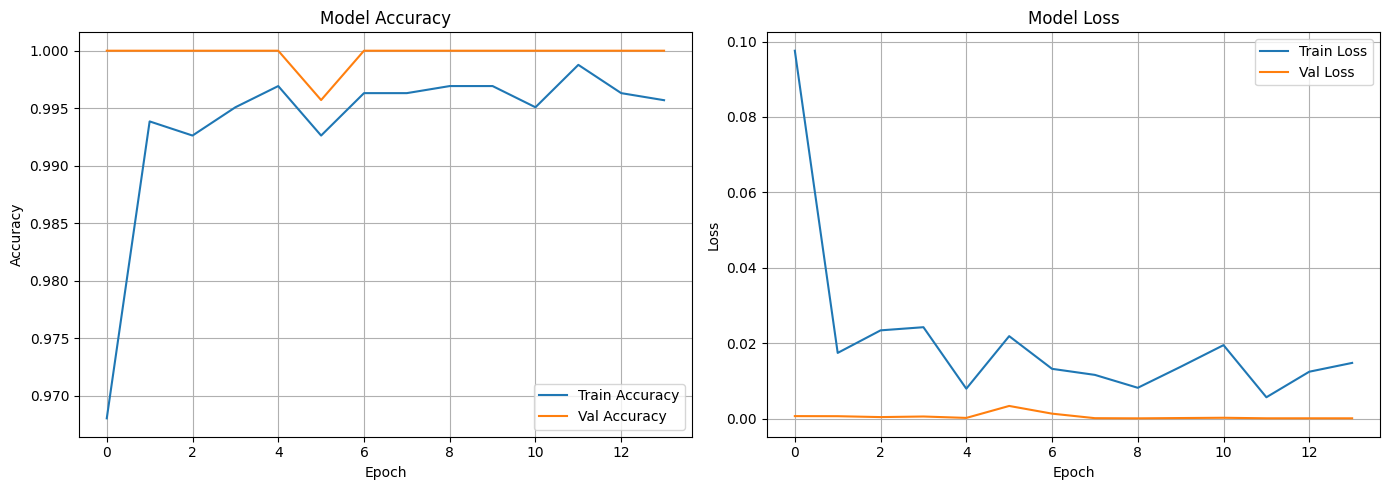

✓ Plots saved


In [14]:
#@title Plot Training History
print("\n[5/7] Plotting training history...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plots saved")



[6/7] Evaluating model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

MODEL EVALUATION RESULTS
Accuracy:  0.9978
Precision: 0.9979
Recall:    0.9978
F1-Score:  0.9978


Classification Report:
              precision    recall  f1-score   support

  FAW_Absent       1.00      1.00      1.00       233
 FAW_Present       1.00      1.00      1.00       232

    accuracy                           1.00       465
   macro avg       1.00      1.00      1.00       465
weighted avg       1.00      1.00      1.00       465



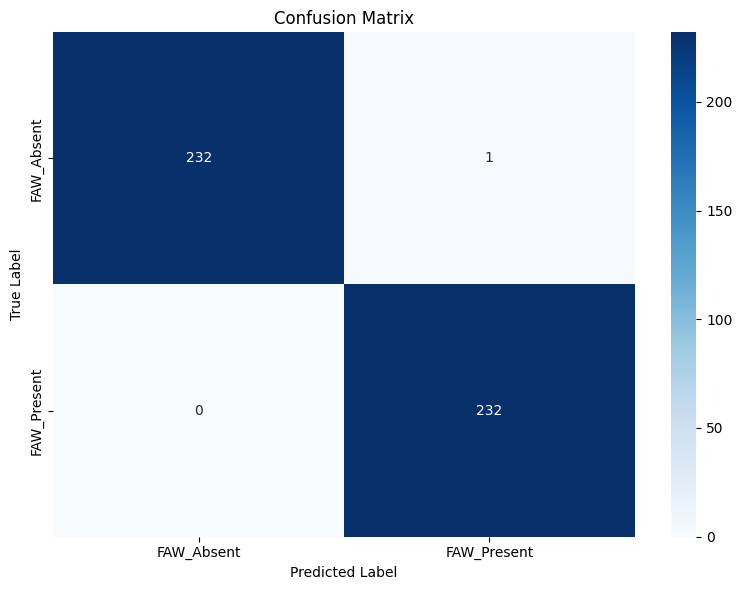

In [15]:
#@title Evaluate Model
print("\n[6/7] Evaluating model on test set...")

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("\n" + "="*50)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



In [29]:
# Define a helper to get the concrete function for inference
def get_concrete_inference_function(keras_model, img_size):
    # Define the input signature for the tf.function
    input_signature = [
        tf.TensorSpec(shape=(None, *img_size, 3), dtype=tf.float32, name="input_tensor")
    ]

    # Define the tf.function that wraps the Keras model's call method
    @tf.function(input_signature=input_signature)
    def serving_fn(input_tensor):
        # Call the Keras model for inference. Set training=False to disable dropout/batchnorm updates.
        predictions = keras_model(input_tensor, training=False)
        return predictions  # Return predictions directly

    # Get the concrete function from the tf.function
    # When input_signature is provided to @tf.function, calling get_concrete_function() without arguments works.
    return serving_fn.get_concrete_function()

#@title Export Model to ONNX
print("\n[7/7] Exporting model to ONNX format...")

try:
    # Obtain the concrete function from the helper
    concrete_func = get_concrete_inference_function(model, IMG_SIZE)

    # Convert the concrete function to ONNX using from_function.
    # The input_signature argument expects a list of TensorSpec.
    # concrete_func.structured_input_signature[0] returns a tuple of TensorSpec, so convert to list.
    model_proto, _ = tf2onnx.convert.from_function(
        concrete_func,
        input_signature=list(concrete_func.structured_input_signature[0]),  # Ensure it's a list of TensorSpecs
        output_names=["output_softmax"],  # Explicitly name the output tensor
        opset=13
    )
    onnx.save(model_proto, 'faw_model.onnx')
    print(f"✓ Model successfully exported to faw_model.onnx")

    # Verify the ONNX model
    onnx_model = onnx.load('faw_model.onnx')
    onnx.checker.check_model(onnx_model)
    print("✓ ONNX model verified successfully")

    # Print model size
    model_size = os.path.getsize('faw_model.onnx') / (1024 * 1024)
    print(f"✓ Model size: {model_size:.2f} MB")

except Exception as e:
    print(f"Error exporting to ONNX: {e}")

# Save model in Keras format
model.save('faw_model.h5')
print("✓ Model also saved as faw_model.h5")


[7/7] Exporting model to ONNX format...


Error exporting to ONNX: from_function() got an unexpected keyword argument 'output_names'
✓ Model also saved as faw_model.h5


In [30]:
#@title Summary
print("\n" + "="*60)
print("TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nFinal Results:")
print(f"  • Test Accuracy:  {acc:.4f}")
print(f"  • Test Precision: {prec:.4f}")
print(f"  • Test Recall:    {rec:.4f}")
print(f"  • Test F1-Score:  {f1:.4f}")
print("\nOutput Files:")
print("  • faw_model.onnx (ONNX format)")
print("  • faw_model.h5 (Keras format)")
print("  • confusion_matrix.png")
print("  • training_history.png")
print("="*60)



TRAINING PIPELINE COMPLETED SUCCESSFULLY!

Final Results:
  • Test Accuracy:  0.9978
  • Test Precision: 0.9979
  • Test Recall:    0.9978
  • Test F1-Score:  0.9978

Output Files:
  • faw_model.onnx (ONNX format)
  • faw_model.h5 (Keras format)
  • confusion_matrix.png
  • training_history.png
